# Project 1 - Adding Numbers

In [23]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

In [24]:
def get_data():
    data = np.random.randint(-10, 10, (1000, 2))
    labels = np.sum(data, axis=1).reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, shuffle=True, test_size=0.2)
    
    train_ds = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
    test_ds = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long())
    
    trainLoader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
    testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])
    
    return trainLoader, testLoader

In [25]:
trainLoader, testLoader = get_data()

In [26]:
def createModel():
    class SumNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(2, 16)
            self.h1 = nn.Linear(16, 8)
            self.op = nn.Linear(8, 1)
        
        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            return self.op(x)
    
    net = SumNet()
    lossfn = nn.MSELoss()
    optim = torch.optim.SGD(net.parameters(), lr = 0.01)
    
    return net, lossfn, optim

In [27]:
# test Model

X, y = next(iter(trainLoader))
n, _, _ = createModel()
n(X)

tensor([[ 0.1189],
        [-0.6455],
        [-1.0887],
        [ 0.4939],
        [-0.2175],
        [ 0.5682],
        [-1.1139],
        [-0.3471],
        [-0.5291],
        [-0.0135],
        [-0.3471],
        [ 0.0956],
        [ 0.3517],
        [-1.1699],
        [-0.5399],
        [-0.4802],
        [-0.6910],
        [-0.2966],
        [-0.6359],
        [-0.6528],
        [ 0.4084],
        [-0.6596],
        [-0.5636],
        [ 0.3894],
        [-0.2341],
        [-0.6359],
        [-0.1382],
        [-1.2382],
        [-0.2544],
        [ 0.4530],
        [-0.2341],
        [ 0.0636]], grad_fn=<AddmmBackward0>)

In [28]:
def trainModel(trainLoader, testLoader):
    net, lossfn, optim = createModel()
    
    nEp = 10
    trainAcc, testAcc, losses = [], [], torch.zeros(nEp)
    
    for i in range(nEp):
        batchAcc, batchLoss = [], []
        
        for X, y in trainLoader:
            yH = net(X)
            loss = lossfn(yH,y.float())
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            
            matches = torch.round(yH) == y
            matchesNum = matches.float()
            accPt = 100*torch.mean(matchesNum)
            batchAcc.append(accPt)
        # end of batch loop    
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        with torch.no_grad():
            X, y = next(iter(testLoader))
            yH = net(X)
            testAcc.append( 100*torch.mean((torch.round(yH)==y).float()) )
    
    # end of trainLoop
    
    return net, trainAcc, testAcc, losses

In [29]:
trainLoader, testLoader = get_data()

for i in range(10):
    net, trainAcc, testAcc, losses = trainModel(trainLoader, testLoader)
    print(f'Model instance {i+1} - train Accuracy : {np.mean(trainAcc):.2f}, test Accuracy : {np.mean(testAcc):.2f}')
    
    # unseen random data again
    test_data = torch.randint(-10, 11, (1000,2)).float()
    test_labels = torch.sum(test_data, axis=1, keepdim=True)
    yH = net(test_data)
    unseen_acc = 100*torch.mean((torch.round(yH)==test_labels).float()).item()
    print(f'Unseen data accuracy: {unseen_acc:.2f}')

Model instance 1 - train Accuracy : 88.65, test Accuracy : 93.00
Unseen data accuracy: 100.00
Model instance 2 - train Accuracy : 84.86, test Accuracy : 83.85
Unseen data accuracy: 100.00
Model instance 3 - train Accuracy : 89.05, test Accuracy : 87.50
Unseen data accuracy: 100.00
Model instance 4 - train Accuracy : 79.62, test Accuracy : 85.55
Unseen data accuracy: 99.70
Model instance 5 - train Accuracy : 70.01, test Accuracy : 70.40
Unseen data accuracy: 100.00
Model instance 6 - train Accuracy : 82.66, test Accuracy : 83.80
Unseen data accuracy: 99.60
Model instance 7 - train Accuracy : 89.28, test Accuracy : 90.20
Unseen data accuracy: 85.10
Model instance 8 - train Accuracy : 72.89, test Accuracy : 76.90
Unseen data accuracy: 97.30
Model instance 9 - train Accuracy : 87.89, test Accuracy : 91.35
Unseen data accuracy: 100.00
Model instance 10 - train Accuracy : 83.31, test Accuracy : 88.85
Unseen data accuracy: 98.20


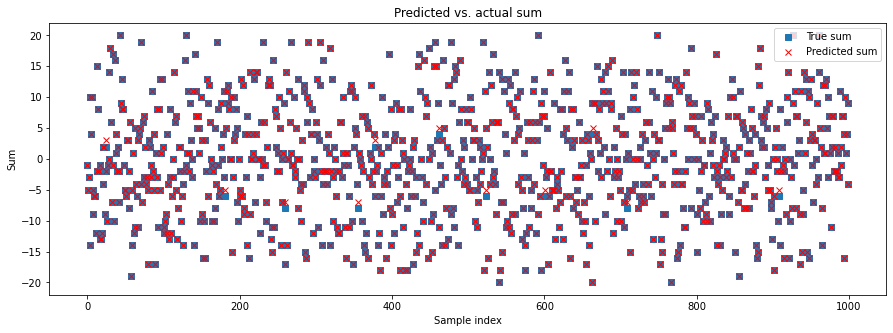

In [30]:
# some plots from the final model

data = torch.randint(low=-10,high=11,size=(1000,2)).float()
labels = torch.sum(data,axis=1,keepdim=True)

# evaluate the model and compute accuracy
with torch.no_grad():
    predictions = net(data)


# true and predicted values
fig = plt.figure(figsize=(15,5))
plt.plot(labels,'s')
plt.plot(np.round(predictions.detach()),'rx')
plt.legend(['True sum','Predicted sum'])
plt.xlabel('Sample index')
plt.ylabel('Sum')
plt.title('Predicted vs. actual sum')
plt.show()

# Project 2 - Predicting heart Disease

Dataset - https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

In [146]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data')

In [150]:
def process_data(df):
    # naming columns and separating data and labels, removing null valued rows
    df.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']
    df = df.replace('?',np.nan).dropna()
    
    # standardizing numeric cols
    cols2zscore = df.keys()
    cols2zscore = cols2zscore.drop(['sex','fbs','exang', 'DISEASE'])
    cols2zscore
    
    for c in cols2zscore:
        d = pd.to_numeric(data[c]) # force to numeric (addresses some data-format issues)
        data[c] = (d - d.mean())/d.std(ddof=1)
        
    df['DISEASE'][df['DISEASE'] > 0] = 1   # binarizing the labels
    
    dataT  = torch.tensor( data[data.keys().drop('DISEASE')].values ).float()
    labels = torch.tensor( data['DISEASE'].values ).float()

    return dataT, labels

In [157]:
dataT, labels = process_data(df)
labels = labels[:,None]

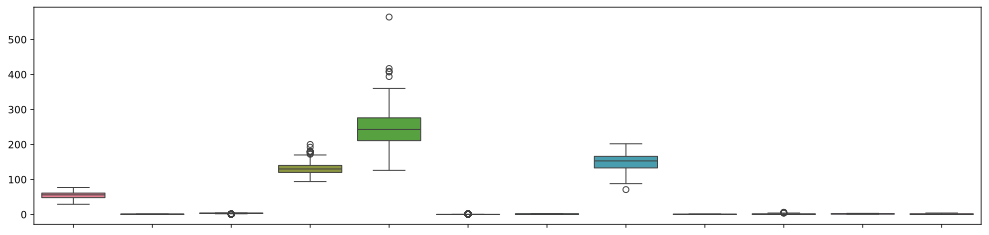

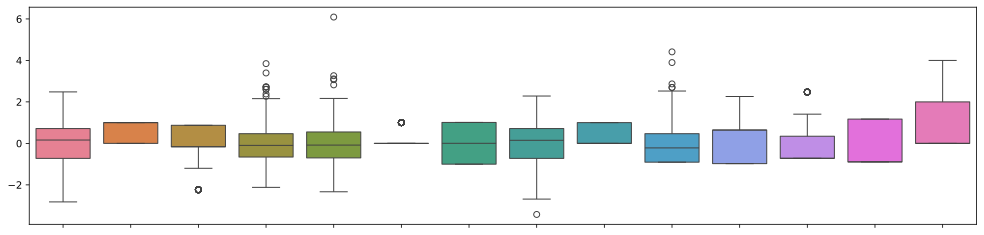

In [122]:

# url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
# data = pd.read_csv(url,sep=',',header=None)
# data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']


# # data contain some ?'s; replace with NaN and drop those rows
# data = data.replace('?',np.nan).dropna()

# # z-score the non-categorical columns
# cols2zscore = data.keys()
# cols2zscore = cols2zscore.drop(['sex','fbs','exang','DISEASE'])
# cols2zscore

# for c in cols2zscore:
#   d = pd.to_numeric(data[c]) # force to numeric (addresses some data-format issues)
#   data[c] = (d - d.mean())/d.std(ddof=1)

# # re-code events to 0 (absent) and 1 (present)
# data['DISEASE'][data['DISEASE']>0] = 1

# # Re-organize the data: train/test in DataLoaders

# # convert from pandas dataframe to tensor
# dataT  = torch.tensor( data[data.keys().drop('DISEASE')].values ).float()
# labels = torch.tensor( data['DISEASE'].values ).float()

In [158]:
# split into train and test

X_train, X_test, y_train, y_test = train_test_split(dataT, labels, shuffle=True, test_size=50)
    
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

trainLoader = DataLoader(train_ds, batch_size=16, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [159]:
# create Model
def createModel():
    net = nn.Sequential(
        nn.Linear(dataT.shape[1], 32),
        nn.ReLU(),
#         nn.Dropout(0.25),
        nn.Linear(32, 64),
        nn.ReLU(),
#         nn.Dropout(0.25),
#         nn.Dropout(0.5),
        nn.Linear(64, 10),
        nn.ReLU(),
#         nn.Dropout(0.5),
        nn.Linear(10, 1)
    )
    
    lossfn = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(net.parameters(), lr = 0.0001) #, weight_decay=0.01)
    
    return net, lossfn, optim

In [156]:
# #testing the model
# net, _, _ = createModel()

# a, _ = next(iter(trainLoader))
# net(a)

tensor([[0.1239],
        [0.1655],
        [0.1482],
        [0.1263],
        [0.0945],
        [0.1186],
        [0.1281],
        [0.1157],
        [0.1386],
        [0.1321],
        [0.1445],
        [0.1310],
        [0.1219],
        [0.1340],
        [0.1320],
        [0.1118]], grad_fn=<AddmmBackward0>)

In [160]:
def trainModel(trainLoader, testLoader):
    net, lossfn, optim = createModel()
    
    nEp = 100
    trainAcc, testAcc, losses = [], [], torch.zeros(nEp)
    
    # count total number of weights in model
    nWeights = 0
    for pname, weight in net.named_parameters():
        nWeights += weight.numel() # adding number of trainable params i.e. weights
        
    for i in range(nEp):
        batchAcc, batchLoss = [], []
        
        for X, y in trainLoader:
            yH = net(X)
            loss = lossfn(yH,y.float())
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
#             # Adding L1 term
#             L1_term = torch.tensor(0., requires_grad=True)
            
#             # sum all abs(weights)
#             for pname, weight in net.named_parameters():
#                 if 'bias' not in pname:
#                     L1_term = L1_term + torch.sum(torch.abs(weight))
                
#             # add it to loss term
#             loss += 0.1*L1_term/nWeights
            
            batchLoss.append(loss.item())
            
            matches = (torch.sigmoid(yH) > 0.5) == y
            matchesNum = matches.float()
            accPt = 100*torch.mean(matchesNum)
            batchAcc.append(accPt)
        # end of batch loop    
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        with torch.no_grad():
            X, y = next(iter(testLoader))
            yH = net(X)
            testAcc.append( 100*torch.mean(((torch.sigmoid(yH) > 0.5)==y).float()) )
    
    # end of trainLoop
    
    return net, trainAcc, testAcc, losses

In [141]:
# for i in range(10):
#     net, trainAcc, testAcc, losses = trainModel(trainLoader, testLoader)
#     print(f'Model instance {i+1} - train Accuracy : {np.mean(trainAcc):.2f}, test Accuracy : {np.mean(testAcc):.2f}')

Model instance 1 - train Accuracy : 79.27, test Accuracy : 78.26
Model instance 2 - train Accuracy : 77.78, test Accuracy : 78.68
Model instance 3 - train Accuracy : 80.45, test Accuracy : 78.54
Model instance 4 - train Accuracy : 80.35, test Accuracy : 79.68
Model instance 5 - train Accuracy : 78.20, test Accuracy : 78.12
Model instance 6 - train Accuracy : 78.06, test Accuracy : 79.14
Model instance 7 - train Accuracy : 75.66, test Accuracy : 73.60
Model instance 8 - train Accuracy : 79.62, test Accuracy : 79.78
Model instance 9 - train Accuracy : 81.49, test Accuracy : 77.46
Model instance 10 - train Accuracy : 79.18, test Accuracy : 80.62


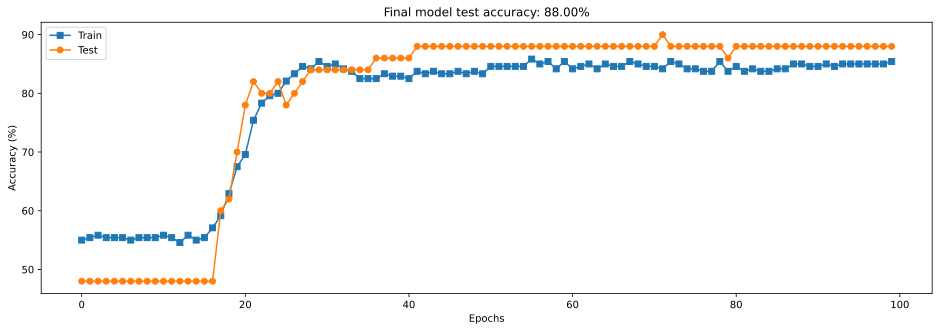

In [161]:
fig,ax = plt.subplots(1,1,figsize=(16,5))

net, trainAcc, testAcc, losses = trainModel(trainLoader, testLoader)

ax.plot(trainAcc,'s-',label='Train')
ax.plot(testAcc,'o-',label='Test')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy (%)')
ax.set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax.legend()

plt.show()

# Project 3 - Missing Data

Mask values from 'residual sugar' column for 10 rows of wine quality dataset. Put those missing-valued rows in test data and remaining in train data. Train DL model to predict on test data.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

df = pd.read_csv(url,sep=';')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [2]:
data2 = df.copy()

# z-scoring all columns
data2 = (data2 - data2.mean())/data2.std(ddof=1)

In [3]:
data2

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910,-0.584594,-0.787576
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074,-0.584594,-0.787576
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036,-0.584594,0.450707
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217415,0.403103,-0.980362,-0.382151,0.053829,1.541571,-0.075020,-0.978459,0.899605,-0.461036,0.072271,-0.787576
1595,-1.389721,0.123866,-0.877693,-0.240300,-0.541090,2.210777,0.137777,-0.861893,1.353012,0.600867,0.729136,0.450707
1596,-1.159980,-0.099523,-0.723690,-0.169374,-0.243630,1.254769,-0.196617,-0.533387,0.705287,0.541872,0.541460,0.450707
1597,-1.389721,0.654416,-0.775024,-0.382151,-0.264878,1.541571,-0.075020,-0.676446,1.676875,0.305894,-0.209243,-0.787576


In [4]:
mRowIdx = np.random.randint(0, df.shape[0], 10)

mRowIdx

array([1341,  535,  361,  516,  571,  328,  916, 1476,  698,  181])

In [5]:
test_data = data2[data2.index.isin(mRowIdx)]
test_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
181,0.333332,0.458950,1.124349,-0.382151,3.878302,0.681164,1.931345,0.240191,-1.237888,2.134727,-1.053784,-0.787576
328,2.917910,-1.439858,1.791696,0.043403,-0.116148,-0.944051,-0.774207,1.829735,-0.978798,0.069915,-0.678432,0.450707
361,0.161027,-0.434607,0.200329,0.043403,-0.031160,0.489962,0.107377,0.770039,0.381425,1.485786,-0.490756,0.450707
516,2.400995,0.403103,1.124349,1.249138,0.266299,-1.039652,-0.987003,2.253613,-0.395846,0.482878,1.386002,0.450707
535,0.448202,-1.719094,-0.159011,-0.311225,-0.201136,-1.422055,-0.561411,1.193917,0.640515,1.249808,-0.115405,0.450707
571,-1.217415,-0.937232,-0.159011,-0.240300,0.160064,0.298760,-0.135818,-1.137414,1.676875,-0.520031,1.198326,0.450707
698,0.620507,0.486874,0.046326,0.468956,-0.009913,0.203159,0.776165,1.776750,-0.007210,-0.756009,-0.678432,-0.787576
916,-1.734331,1.045347,-0.415683,-0.736779,1.562371,-0.848450,0.472171,-1.481815,2.000738,-0.284052,0.541460,-0.787576
1341,-0.470759,-0.099523,-1.288368,-0.594928,-0.073654,-0.274845,-0.470212,-0.724132,0.316652,-0.697015,0.072271,0.450707
1476,0.907683,-0.155370,1.175683,7.987070,2.497242,3.071185,1.080160,3.005997,-0.978798,0.541872,-1.522973,-0.787576


In [6]:
train_data = data2[~data2.index.isin(mRowIdx)]
train_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910,-0.584594,-0.787576
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074,-0.584594,-0.787576
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036,-0.584594,0.450707
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217415,0.403103,-0.980362,-0.382151,0.053829,1.541571,-0.075020,-0.978459,0.899605,-0.461036,0.072271,-0.787576
1595,-1.389721,0.123866,-0.877693,-0.240300,-0.541090,2.210777,0.137777,-0.861893,1.353012,0.600867,0.729136,0.450707
1596,-1.159980,-0.099523,-0.723690,-0.169374,-0.243630,1.254769,-0.196617,-0.533387,0.705287,0.541872,0.541460,0.450707
1597,-1.389721,0.654416,-0.775024,-0.382151,-0.264878,1.541571,-0.075020,-0.676446,1.676875,0.305894,-0.209243,-0.787576


In [7]:
y_train = train_data['residual sugar']
X_train = train_data.drop(['residual sugar'], axis=1)
y_test = test_data['residual sugar']
X_test = test_data.drop(['residual sugar'], axis=1)

In [8]:
X_test

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
181,0.333332,0.458950,1.124349,3.878302,0.681164,1.931345,0.240191,-1.237888,2.134727,-1.053784,-0.787576
328,2.917910,-1.439858,1.791696,-0.116148,-0.944051,-0.774207,1.829735,-0.978798,0.069915,-0.678432,0.450707
361,0.161027,-0.434607,0.200329,-0.031160,0.489962,0.107377,0.770039,0.381425,1.485786,-0.490756,0.450707
516,2.400995,0.403103,1.124349,0.266299,-1.039652,-0.987003,2.253613,-0.395846,0.482878,1.386002,0.450707
535,0.448202,-1.719094,-0.159011,-0.201136,-1.422055,-0.561411,1.193917,0.640515,1.249808,-0.115405,0.450707
571,-1.217415,-0.937232,-0.159011,0.160064,0.298760,-0.135818,-1.137414,1.676875,-0.520031,1.198326,0.450707
698,0.620507,0.486874,0.046326,-0.009913,0.203159,0.776165,1.776750,-0.007210,-0.756009,-0.678432,-0.787576
916,-1.734331,1.045347,-0.415683,1.562371,-0.848450,0.472171,-1.481815,2.000738,-0.284052,0.541460,-0.787576
1341,-0.470759,-0.099523,-1.288368,-0.073654,-0.274845,-0.470212,-0.724132,0.316652,-0.697015,0.072271,0.450707
1476,0.907683,-0.155370,1.175683,2.497242,3.071185,1.080160,3.005997,-0.978798,0.541872,-1.522973,-0.787576


In [9]:
y_test

181    -0.382151
328     0.043403
361     0.043403
516     1.249138
535    -0.311225
571    -0.240300
698     0.468956
916    -0.736779
1341   -0.594928
1476    7.987070
Name: residual sugar, dtype: float64

In [10]:
xTrain = torch.tensor(X_train.values).float()
xTest = torch.tensor(X_test.values).float()
yTrain = torch.tensor(y_train.values[:, None]).float()
yTest = torch.tensor(y_test.values[:, None]).float()


train_ds = TensorDataset(xTrain, yTrain)
test_ds = TensorDataset(xTest, yTest)

In [11]:
trainLoader = DataLoader(train_ds, batch_size=16, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [12]:
def createModel():
    class SumNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(11, 16)
            self.h1 = nn.Linear(16, 8)
            self.op = nn.Linear(8, 1)
        
        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            return self.op(x)
    
    net = SumNet()
    lossfn = nn.MSELoss()
    optim = torch.optim.Adam(net.parameters(), lr = 0.001)
    
    return net, lossfn, optim

In [13]:
# test Model

# X, y = next(iter(trainLoader))
# n, _, _ = createModel()
# n(X)

In [25]:
def trainModel(trainLoader, testLoader):
    net, lossfn, optim = createModel()
    
    nEp = 1000
    losses = torch.zeros(nEp)
    
    for i in range(nEp):
        batchLoss = []
        
        for X, y in trainLoader:
            yH = net(X)
            loss = lossfn(yH,y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            
        # end of batch loop    
        
        losses[i] = np.mean(batchLoss)
    
    # end of trainLoop
    
    return net, losses

In [26]:
net, losses = trainModel(trainLoader, testLoader)

In [27]:
with torch.no_grad():
    yH_train = net(xTrain)
    yH_test = net(xTest)

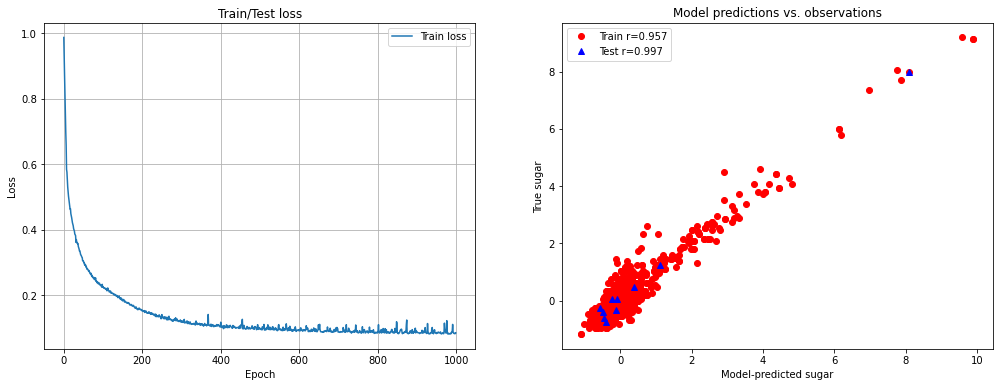

In [28]:
fig,ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(losses,label='Train loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


ax[1].plot(yH_train.detach(),yTrain,'ro')
ax[1].plot(yH_test.detach(),yTest,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yH_train.detach().T,yTrain.T)[1,0]
corrTest  = np.corrcoef(yH_test.detach().T, yTest.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()

In [29]:
yTest

tensor([[-0.3822],
        [ 0.0434],
        [ 0.0434],
        [ 1.2491],
        [-0.3112],
        [-0.2403],
        [ 0.4690],
        [-0.7368],
        [-0.5949],
        [ 7.9871]])

In [30]:
yH_test

tensor([[-0.4921],
        [-0.0844],
        [-0.2447],
        [ 1.1189],
        [-0.1323],
        [-0.5621],
        [ 0.3696],
        [-0.3994],
        [-0.4574],
        [ 8.0912]])